# Parse uniqueness.csv

In [2]:
import pandas as pd
import numpy as np
import re

# Read the CSV file
df = pd.read_csv('uniqueness.csv')

# Initialize the 3D array: (256 challenges, 10 iterations, 5 values)
data_array = np.zeros((256, 10, 5))

# Regex patterns to extract parameters
param_re = re.compile(r"ch(\d+)=([\d.]+)")
mc_re = re.compile(r"mc_iteration=(\d+)")

current_challenge_idx = -1
current_mc = -1
challenges = []

for idx, row in df.iterrows():
    # Check if this is a Parameters row
    if pd.notna(row['Point']) and str(row['Point']).startswith('Parameters:'):
        param_str = str(row['Point'])
        
        # Extract challenge bits
        ch_matches = param_re.findall(param_str)
        if ch_matches:
            ch_values = [float(val) for ch_num, val in sorted(ch_matches, key=lambda x: int(x[0]))]
            
            # Check if this is a new challenge configuration
            if ch_values not in challenges:
                challenges.append(ch_values)
                current_challenge_idx = len(challenges) - 1
            else:
                current_challenge_idx = challenges.index(ch_values)
        
        # Extract MC iteration
        mc_match = mc_re.search(param_str)
        if mc_match:
            current_mc = int(mc_match.group(1)) - 1  # Convert to 0-based index
    
    # Check if this is a data row with b0, b1, b2, b3, b4
    elif pd.notna(row['Test']) and row['Test'] == 'base_setup':
        output = row['Output']
        value = row['Nominal']
        
        if pd.notna(output) and pd.notna(value):
            # Extract b index (b0, b1, b2, b3, b4)
            b_idx = int(output[1])  # Gets the number from 'b0', 'b1', etc.
            
            # Store the value
            if current_challenge_idx >= 0 and current_mc >= 0:
                data_array[current_challenge_idx, current_mc, b_idx] = value

print(f"Array shape: {data_array.shape}")
print(f"Number of unique challenges found: {len(challenges)}")
print(f"First challenge, first iteration: {data_array[0, 0, :]}")
print(f"First challenge values: {challenges[0]}")

Array shape: (256, 10, 5)
Number of unique challenges found: 256
First challenge, first iteration: [ 0.04981  -0.001415 -0.02488  -0.07184   0.009985]
First challenge values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Convert to binary

In [3]:
# Convert to binary
binary_array = (data_array > 0).astype(int)

print(f"Binary array shape: {binary_array.shape}")
print(f"First challenge, first iteration (binary): {binary_array[0, 0, :]}")
print(f"Original values: {data_array[0, 0, :]}")

Binary array shape: (256, 10, 5)
First challenge, first iteration (binary): [1 0 0 0 1]
Original values: [ 0.04981  -0.001415 -0.02488  -0.07184   0.009985]


# Compute uniqueness

Average inter-chip Hamming distance: 51.23611111111111 %


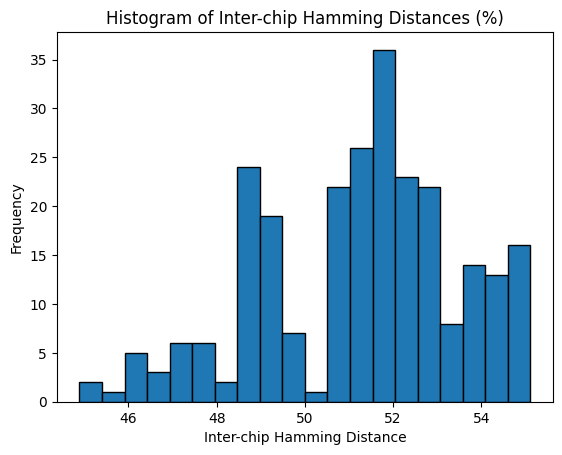

In [9]:
num_CRP = binary_array.shape[0]
num_chips = binary_array.shape[1]
resp_length = binary_array.shape[2]

d_inter = []

for i in range(num_CRP):
    avg_hd = 0
    for j in range(num_chips):
        for k in range(j+1, num_chips):
            hd = np.sum(binary_array[i,j,:] != binary_array[i,k,:])
            avg_hd += hd
    avg_hd /= (num_chips*(num_chips-1)/2)
    d_inter.append(avg_hd/resp_length)

d_inter = np.array(d_inter) * 100
print("Average inter-chip Hamming distance:", np.mean(d_inter), "%")

#Plot a histogram of interchip Hamming distances
import matplotlib.pyplot as plt
plt.hist(d_inter, bins=20, edgecolor='black')
plt.xlabel("Inter-chip Hamming Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Inter-chip Hamming Distances (%)")
plt.show()


# Compute bit aliasing

Average bit aliasing: 46.875 %


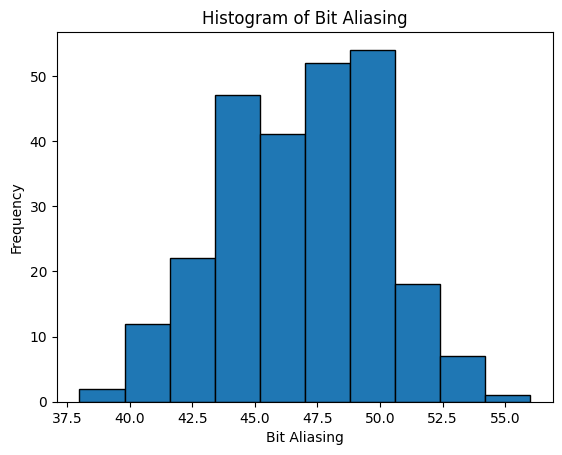

In [13]:
num_CRP = binary_array.shape[0]
num_chips = binary_array.shape[1]
resp_length = binary_array.shape[2]

bit_aliasing = []
for i in range(num_CRP):
    avg_bit_aliasing = 0
    for j in range(resp_length):
        count = 0
        for k in range(num_chips):
            if binary_array[i,k,j] == 1:
                count += 1
        avg_bit_aliasing += count/(num_chips)
    avg_bit_aliasing /= resp_length
    bit_aliasing.append(avg_bit_aliasing)

bit_aliasing = np.array(bit_aliasing)*100

print("Average bit aliasing:", np.mean(bit_aliasing), "%")
#Plot a histogram of bit aliasing

import matplotlib.pyplot as plt
plt.hist(bit_aliasing, bins=10, edgecolor='black')
plt.xlabel("Bit Aliasing")
plt.ylabel("Frequency")
plt.title("Histogram of Bit Aliasing")
plt.show()

# Parse reliability.csv

Assuming that all text has been removed in the file and the format is 1280x9 table of values (which will be reshaped to 256x9x5). The first column is nominal conditions and will be used for uniformity calculation. We also need to calculate the worst corner in terms of reliability.

In [ ]:
import pandas as pd

def read_csv(filename):
    df = pd.read_csv(filename, delimiter=',', header=None)
    numpy_array = df.to_numpy()
    reshaped_data = numpy_array.reshape(256, 5, 9).transpose(0, 2, 1)
    return reshaped_data

data_array = read_csv('reliability.csv')
print(len(data_array))

FileNotFoundError: [Errno 2] No such file or directory: 'reliability.csv'

# Convert to Binary

In [ ]:
# Convert to binary
corner_data = (data_array > 0).astype(int)

print(f"Binary array shape: {corner_data.shape}")
print(f"First challenge, first iteration (binary): {corner_data[0, 0, :]}")
print(f"Original values: {data_array[0, 0, :]}")

# Compute Uniformity (Nominal)

In [ ]:
num_CRP = corner_data.shape[0]
num_corners = corner_data.shape[1] #Including nominal
resp_length = corner_data.shape[2]

print("number of corners is:", num_corners) # Verification

uniformities = []

for i in range(num_CRP):

    uniformity = corner_data[i][0].mean()
    uniformities.append(uniformity)

uniformities = np.array(uniformities)*100

print("Average uniformity:", np.mean(uniformities), "%")
#Plot a histogram of uniformities

import matplotlib.pyplot as plt
plt.hist(uniformities, bins=10, edgecolor='black')
plt.xlabel("Uniformity")
plt.ylabel("Frequency")
plt.title("Histogram of Uniformities")
plt.show()

# Compute Reliability over corners

In [ ]:
num_CRP = corner_data.shape[0]
num_corners = corner_data.shape[1] 
resp_length = corner_data.shape[2]

reliabilities = []

for i in range(num_CRP):

    reliability = 0
    for j in range(1,num_corners):
        hd = np.sum(corner_data[i][0,:] != corner_data[i][j,:])
        reliability += (resp_length - hd)/resp_length
    reliability /= (num_corners - 1)
    reliabilities.append(reliability)

reliabilities = np.array(reliabilities)*100

print("Average reliability:", np.mean(reliabilities), "%")
#Plot a histogram of reliabilities

import matplotlib.pyplot as plt
plt.hist(reliabilities, bins=10, edgecolor='black')
plt.xlabel("Reliability")
plt.ylabel("Frequency")
plt.title("Histogram of Reliabilities")
plt.show()